# Home Credit Analysis

Goal of this notebook is to answer:

- What factors will affect how much an individual is approved for?
- How does a previous application affect your loan amount?
- Which loan purpose, increase or decrease the amount difference?
- What start time of application, increase or decrease the amount difference? 

Data: https://www.kaggle.com/c/home-credit-default-risk/data

#Importing Data and Loading

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sns
from sklearn.inspection import permutation_importance

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/Shared drives/Project 4 (MATH 3439)/Data/'

Mounted at /content/drive


Loading the Data

In [ ]:
sample_result3 = pd.read_csv(drive_dir + 'result2.csv', nrows=100000)
sample_result3 = sample_result3.dropna(how='any')
# Load 1000 rows 200 times
for i in range(30):
    new_result3 = pd.read_csv(drive_dir + 'result2.csv', nrows=100000, skiprows=range(1,(i+1)*100000))
    new_result3 = new_result3.dropna(how='any')
    sample_result3 = pd.concat([sample_result3, new_result3])

Checking the shape of the data

In [ ]:
sample_result3.shape

Checking for missing values

In [ ]:
for c in sample_result3.columns:
  num_missing = sample_result3[c].isna().sum()
  if num_missing > 0:
    print(f'{c}: {num_missing} ({100*num_missing / sample_result3.shape[0]:.2f}%) missing values')

# Reducing Memory Usage (LOAD PIECEWISE)

Checing for the overall memory usage of the data and each column

In [ ]:
sample_result3.memory_usage().sum() / 10**6

1395.27776

In [ ]:
sample_result3.memory_usage() / 10**6

Index                     22.50448
SK_ID_CURR                22.50448
NAME_CONTRACT_TYPE        22.50448
AMT_ANNUITY_x             22.50448
AMT_APPLICATION           22.50448
                            ...   
AMT_CREDIT_SUM_LIMIT      22.50448
AMT_CREDIT_SUM_OVERDUE    22.50448
CREDIT_TYPE               22.50448
DAYS_CREDIT_UPDATE        22.50448
AMT_ANNUITY_y             22.50448
Length: 62, dtype: float64

### Preparing to reduce data

In [ ]:
sample_result3.dtypes

SK_ID_CURR                  int64
NAME_CONTRACT_TYPE          int64
AMT_ANNUITY_x             float64
AMT_APPLICATION           float64
AMT_CREDIT                float64
                           ...   
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               float64
DAYS_CREDIT_UPDATE        float64
AMT_ANNUITY_y             float64
Length: 61, dtype: object

In [ ]:
int_cols = sample_result3.select_dtypes(int).columns

int_cols

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS_x', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'num_past_apps'],
      dtype='object')

In [ ]:
for c in int_cols:
    print(f'{c}: min = {sample_result3[c].min()}, max = {sample_result3[c].max()}')

SK_ID_CURR: min = 100190, max = 199843
NAME_CONTRACT_TYPE: min = 0, max = 1
WEEKDAY_APPR_PROCESS_START: min = 0, max = 6
HOUR_APPR_PROCESS_START: min = 0, max = 23
FLAG_LAST_APPL_PER_CONTRACT: min = 0, max = 0
NFLAG_LAST_APPL_IN_DAY: min = 1, max = 1
NAME_CASH_LOAN_PURPOSE: min = 2, max = 12
NAME_CONTRACT_STATUS_x: min = 0, max = 0
DAYS_DECISION: min = 4294964376, max = 4294967291
NAME_PAYMENT_TYPE: min = 0, max = 3
CODE_REJECT_REASON: min = 0, max = 0
NAME_TYPE_SUITE: min = 0, max = 6
NAME_CLIENT_TYPE: min = 0, max = 3
NAME_GOODS_CATEGORY: min = 0, max = 25
NAME_PORTFOLIO: min = 1, max = 2
NAME_PRODUCT_TYPE: min = 0, max = 2
CHANNEL_TYPE: min = 2, max = 5
SELLERPLACE_AREA: min = 0, max = 4294967295
NAME_SELLER_INDUSTRY: min = 0, max = 10
NAME_YIELD_GROUP: min = 1, max = 4
PRODUCT_COMBINATION: min = 1, max = 14
num_past_apps: min = 1, max = 286


In [ ]:
float_cols = sample_result3.select_dtypes(float).columns

float_cols

Index(['AMT_ANNUITY_x', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'RATE_DOWN_PAYMENT', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT', 'MONTHS_BALANCE',
       'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS_y',
       'SK_DPD', 'SK_DPD_DEF', 'CREDIT_ACTIVE', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY_y'],
      dtype='object')

In [ ]:
for c in float_cols:
    print(f'{c}: min = {sample_result3[c].min()}, max = {sample_result3[c].max()}')

AMT_ANNUITY_x: min = 758.7, max = 65985.435
AMT_APPLICATION: min = 12055.5, max = 897750.0
AMT_CREDIT: min = 12055.5, max = 897750.0
AMT_DOWN_PAYMENT: min = 0.0, max = 90000.0
AMT_GOODS_PRICE: min = 12055.5, max = 897750.0
RATE_DOWN_PAYMENT: min = 0.0, max = 0.7874437188076603
CNT_PAYMENT: min = 3.0, max = 48.0
DAYS_FIRST_DRAWING: min = 365243.0, max = 365243.0
DAYS_FIRST_DUE: min = -2890.0, max = 365243.0
DAYS_LAST_DUE_1ST_VERSION: min = -2782.0, max = 968.0
DAYS_LAST_DUE: min = -2782.0, max = 365243.0
DAYS_TERMINATION: min = -2762.0, max = 365243.0
NFLAG_INSURED_ON_APPROVAL: min = 0.0, max = 1.0
NUM_INSTALMENT_VERSION: min = 0.0, max = 22.0
NUM_INSTALMENT_NUMBER: min = 1.0, max = 155.0
DAYS_INSTALMENT: min = -2921.0, max = -2.0
DAYS_ENTRY_PAYMENT: min = -2963.0, max = -2.0
AMT_INSTALMENT: min = 0.0, max = 2101494.0
AMT_PAYMENT: min = 0.0, max = 2101494.0
MONTHS_BALANCE: min = -96.0, max = -1.0
CNT_INSTALMENT: min = 1.0, max = 60.0
CNT_INSTALMENT_FUTURE: min = 0.0, max = 60.0
NAME_CON

In [ ]:
sample3_floats_df = sample_result3[float_cols]

In [ ]:
sample3_floats_df

,AMT_ANNUITY_x,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,RATE_DOWN_PAYMENT,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS_y,SK_DPD,SK_DPD_DEF,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
7,3501.540,24246.0,26248.5,0.0,24246.0,0.000000,10.0,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,-67.0,10.0,4.0,0.0,0.0,0.0,0.0,-129.0,0.0,602.0,0.0,0.0,0.0,64149.0,54162.0,0.0,0.0,3.0,-5.0,0.0
8,3501.540,24246.0,26248.5,0.0,24246.0,0.000000,10.0,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,-67.0,10.0,4.0,0.0,0.0,0.0,0.0,-79.0,0.0,256.0,0.0,0.0,0.0,98609.0,80203.0,0.0,0.0,3.0,-6.0,0.0
9,3501.540,24246.0,26248.5,0.0,24246.0,0.000000,10.0,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,-67.0,10.0,4.0,0.0,0.0,0.0,0.0,-1494.0,0.0,332.0,0.0,0.0,0.0,990000.0,214240.0,0.0,0.0,3.0,-13.0,4500.0
10,3501.540,24246.0,26248.5,0.0,24246.0,0.000000,10.0,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,-67.0,10.0,4.0,0.0,0.0,0.0,0.0,-181.0,0.0,1280.0,0.0,0.0,0.0,454500.0,454500.0,0.0,0.0,3.0,-139.0,0.0
11,3501.540,24246.0,26248.5,0.0,24246.0,0.000000,10.0,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,-69.0,10.0,6.0,0.0,0.0,0.0,0.0,-129.0,0.0,602.0,0.0,0.0,0.0,64149.0,54162.0,0.0,0.0,3.0,-5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4862.565,36585.0,24228.0,13500.0,36585.0,0.389703,6.0,365243.0,-2325.0,-2175.0,-2175.0,-2160.0,1.0,1.0,4.0,-1313.0,-1326.0,8573.0,8573.0,-56.0,10.0,2.0,0.0,0.0,0.0,0.0,-1101.0,0.0,-741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,-645.0,0.0
99996,4862.565,36585.0,24228.0,13500.0,36585.0,0.389703,6.0,365243.0,-2325.0,-2175.0,-2175.0,-2160.0,1.0,1.0,4.0,-1313.0,-1326.0,8573.0,8573.0,-56.0,10.0,2.0,0.0,0.0,0.0,0.0,-1083.0,0.0,750.0,0.0,8384.0,0.0,180000.0,590157.0,17343.0,0.0,4.0,-483.0,0.0
99997,4862.565,36585.0,24228.0,13500.0,36585.0,0.389703,6.0,365243.0,-2325.0,-2175.0,-2175.0,-2160.0,1.0,1.0,4.0,-1313.0,-1326.0,8573.0,8573.0,-56.0,10.0,2.0,0.0,0.0,0.0,2.0,-2885.0,0.0,-1059.0,-1763.0,0.0,0.0,135000.0,0.0,0.0,0.0,3.0,-543.0,0.0
99998,4862.565,36585.0,24228.0,13500.0,36585.0,0.389703,6.0,365243.0,-2325.0,-2175.0,-2175.0,-2160.0,1.0,1.0,4.0,-1313.0,-1326.0,8573.0,8573.0,-56.0,10.0,2.0,0.0,0.0,0.0,2.0,-840.0,0.0,986.0,-178.0,0.0,0.0,1184211.0,0.0,0.0,0.0,3.0,-175.0,0.0


Dropping real floats so that the ones that are actually integers are converted.

In [ ]:
sample3_false_floats_df = sample3_floats_df.drop(columns= ['AMT_ANNUITY_x', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'RATE_DOWN_PAYMENT'])

In [ ]:
false_floats = sample3_false_floats_df.columns
false_floats

Index(['CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS_y', 'SK_DPD',
       'SK_DPD_DEF', 'CREDIT_ACTIVE', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY_y'],
      dtype='object')

In [ ]:
sample_result3.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY_x,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS_x,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,num_past_apps,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS_y,SK_DPD,SK_DPD_DEF,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
7,162582,1,3501.54,24246.0,26248.5,0.0,24246.0,6,10,0,1,0.0,11,0,4294964480,0,0,5,2,17,2,0,2,20,2,10.0,1,11,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,76,-67.0,10.0,4.0,0.0,0.0,0.0,0.0,-129.0,0.0,602.0,0.0,0.0,0.0,64149.0,54162.0,0.0,0.0,3.0,-5.0,0.0
8,162582,1,3501.54,24246.0,26248.5,0.0,24246.0,6,10,0,1,0.0,11,0,4294964480,0,0,5,2,17,2,0,2,20,2,10.0,1,11,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,76,-67.0,10.0,4.0,0.0,0.0,0.0,0.0,-79.0,0.0,256.0,0.0,0.0,0.0,98609.0,80203.0,0.0,0.0,3.0,-6.0,0.0
9,162582,1,3501.54,24246.0,26248.5,0.0,24246.0,6,10,0,1,0.0,11,0,4294964480,0,0,5,2,17,2,0,2,20,2,10.0,1,11,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,76,-67.0,10.0,4.0,0.0,0.0,0.0,0.0,-1494.0,0.0,332.0,0.0,0.0,0.0,990000.0,214240.0,0.0,0.0,3.0,-13.0,4500.0
10,162582,1,3501.54,24246.0,26248.5,0.0,24246.0,6,10,0,1,0.0,11,0,4294964480,0,0,5,2,17,2,0,2,20,2,10.0,1,11,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,76,-67.0,10.0,4.0,0.0,0.0,0.0,0.0,-181.0,0.0,1280.0,0.0,0.0,0.0,454500.0,454500.0,0.0,0.0,3.0,-139.0,0.0
11,162582,1,3501.54,24246.0,26248.5,0.0,24246.0,6,10,0,1,0.0,11,0,4294964480,0,0,5,2,17,2,0,2,20,2,10.0,1,11,365243.0,-2785.0,-2515.0,-2515.0,-2504.0,1.0,0.0,79.0,-867.0,-867.0,4296.0,4296.0,76,-69.0,10.0,6.0,0.0,0.0,0.0,0.0,-129.0,0.0,602.0,0.0,0.0,0.0,64149.0,54162.0,0.0,0.0,3.0,-5.0,0.0


### Reducing size of columns

In [ ]:
def set_dtypes(df, int_col, float_col):
    dtypes = {}
    for c in int_col:
        if df[c].min() >= -128 & df[c].max() <= 127:
            dtypes[c] = np.int8
        elif df[c].min() >= -32768 & df[c].max() <= 32767:
            dtypes[c] = np.int16
        elif df[c].min() >= -2147483648 & df[c].max() <= 2147483647:
            dtypes[c] = np.int32
        elif df[c].min() >= -9223372036854775808 & df[c].max() <= 9223372036854775807:
            dtypes[c] = np.int64
        elif df[c].min() >= 0 & df[c].max() < 256:
            dtypes[c] = np.uint8
        elif df[c].min() >= 0 & df[c].max() < 65536:
            dtypes[c] = np.uint16
        elif df[c].min() >= 0 & df[c].max() < 4294967295:
            dtypes[c] = np.uint32
        elif df[c].min() >= 0 & df[c].max() < 18446744073709551615:
            dtypes[c] = np.uint64

    for c in float_col:
        if df[c].min() >= -128 and df[c].max() <= 127:
            dtypes[c] = np.int8
        elif df[c].min() >= -32768 and df[c].max() <= 32767:
            dtypes[c] = np.int16
        elif df[c].min() >= -2147483648 and df[c].max() <= 2147483647:
            dtypes[c] = np.int32
        elif df[c].min() >= -9223372036854775808 and df[c].max() <= 9223372036854775807:
            dtypes[c] = np.int64
        elif df[c].min() >= 0 and df[c].max() < 256:
            dtypes[c] = np.uint8
        elif df[c].min() >= 0 and df[c].max() < 65536:
            dtypes[c] = np.uint16
        elif df[c].min() >= 0 and df[c].max() < 4294967295:
            dtypes[c] = np.uint32
        elif df[c].min() >= 0 and df[c].max() < 18446744073709551615:
            dtypes[c] = np.uint64

    return dtypes

In [ ]:
dtypes = set_dtypes(sample_result3, int_cols, false_floats)
dtypes

{'AMT_ANNUITY_y': numpy.int32,
 'AMT_CREDIT_MAX_OVERDUE': numpy.int32,
 'AMT_CREDIT_SUM': numpy.int32,
 'AMT_CREDIT_SUM_DEBT': numpy.int32,
 'AMT_CREDIT_SUM_LIMIT': numpy.int32,
 'AMT_CREDIT_SUM_OVERDUE': numpy.int16,
 'AMT_INSTALMENT': numpy.int32,
 'AMT_PAYMENT': numpy.int32,
 'CHANNEL_TYPE': numpy.int8,
 'CNT_CREDIT_PROLONG': numpy.int8,
 'CNT_INSTALMENT': numpy.int8,
 'CNT_INSTALMENT_FUTURE': numpy.int8,
 'CNT_PAYMENT': numpy.int8,
 'CODE_REJECT_REASON': numpy.int8,
 'CREDIT_ACTIVE': numpy.int8,
 'CREDIT_DAY_OVERDUE': numpy.int16,
 'CREDIT_TYPE': numpy.int8,
 'DAYS_CREDIT': numpy.int16,
 'DAYS_CREDIT_ENDDATE': numpy.int16,
 'DAYS_CREDIT_UPDATE': numpy.int16,
 'DAYS_DECISION': numpy.int64,
 'DAYS_ENDDATE_FACT': numpy.int16,
 'DAYS_ENTRY_PAYMENT': numpy.int16,
 'DAYS_FIRST_DRAWING': numpy.int32,
 'DAYS_FIRST_DUE': numpy.int32,
 'DAYS_INSTALMENT': numpy.int16,
 'DAYS_LAST_DUE': numpy.int32,
 'DAYS_LAST_DUE_1ST_VERSION': numpy.int16,
 'DAYS_TERMINATION': numpy.int32,
 'FLAG_LAST_APPL_P

### Saving data frame (run only once)

In [ ]:
sample_result3.to_csv(drive_dir + 'sample_result3.csv', index = False)

### Loading data frame as assigned data types

In [ ]:
slim_sample_result3 = pd.read_csv(drive_dir + 'sample_result3.csv', dtype=dtypes)

In [ ]:
slim_sample_result3.memory_usage().sum() / 10**6

In [ ]:
slim_sample_result3.head()

In [ ]:
slim_sample_result3.shape

Dropping columns that are duplicates or unimportant

In [ ]:
slim_sample_result3 = slim_sample_result3.drop(columns=['NAME_CONTRACT_STATUS_y', 'DAYS_LAST_DUE_1ST_VERSION', 'num_past_apps',
                                                        'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_TERMINATION', 'DAYS_LAST_DUE',
                                                        'DAYS_DECISION'])
slim_sample_result3 = slim_sample_result3.rename(columns={'NAME_CONTRACT_STATUS_x': 'NAME_CONTRACT_STATUS'})

In [ ]:
slim_sample_result3.head()

In [ ]:
slim_sample_result3['AMT_DIFF'] = slim_sample_result3['AMT_APPLICATION']-slim_sample_result3['AMT_CREDIT']

In [ ]:
singleton_list = []
for col in slim_sample_result3:
  if slim_sample_result3[col].nunique() == 1:
    print(col)
    singleton_list.append(col)
singleton_list

### Run Once, then second cell each time

In [ ]:
ultra_slim = slim_sample_result3.sample(500000)
ultra_slim.to_csv(drive_dir + 'ultra_slim.csv', index = False)

In [ ]:
ultra_slim = pd.read_csv(drive_dir + 'ultra_slim.csv', dtype=dtypes)

# Modeling

##Linear Fit Attempt

Checking the shape of the column `AMT_DIFF`

In [ ]:
ultra_slim['AMT_DIFF'].value_counts()

 0.000        6204
-5940.000      518
-1336.500      274
-14611.500     250
-23544.000     243
              ... 
-17487.000       1
-2029.500        1
-3465.000        1
 2440.125        1
-10723.500       1
Name: AMT_DIFF, Length: 2581, dtype: int64

In [ ]:
ultra_slim.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY_x,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AMT_DIFF
993116,192829,1,3356.55,39163.5,21163.5,18000.0,39163.5,5,10,0,1,0.500559,11,0,0,0,6,2,17,2,0,2,101,2,8,3,11,0,1,1,-717,-719,20380,304779,-4,36,33,0,0,2,-2496,0,31144,-52,0,0,74700,54787,0,0,4,-52,0,18000.0
1462430,147912,1,7465.23,62955.0,62262.0,6300.0,62955.0,4,16,0,1,0.100074,11,0,3,0,6,2,6,2,0,2,50,4,12,1,7,0,0,20,-2889,-2889,403,403,-59,12,1,0,0,0,-388,0,23689,0,0,0,225000,0,225000,0,4,-241,0,693.0
2178105,164041,1,12342.87,132052.5,130612.5,13207.5,132052.5,3,11,0,1,0.100015,11,0,0,0,1,2,1,2,0,2,1200,4,12,3,7,0,0,49,-1642,-1642,3503,3503,-2,60,55,0,0,0,-891,0,935,0,0,0,315000,203971,0,0,3,-38,12600,1440.0
2122127,110567,1,27332.64,292455.0,266400.0,45000.0,292455.0,3,13,0,1,0.157383,11,0,3,0,6,2,1,2,0,2,1750,4,12,4,7,0,0,4,-522,-522,5220,5220,-42,18,12,0,0,2,-1431,0,-335,-701,0,0,1945008,0,0,0,1,-701,0,26055.0
2725335,172623,0,18595.26,202500.0,222547.5,0.0,202500.0,1,11,0,1,0.000000,12,0,0,0,6,2,25,1,2,3,4294967295,10,18,1,4,1,0,164,-625,-625,1371,1371,-25,24,19,0,0,0,-545,0,1281,0,0,0,1350000,0,0,0,3,-39,33516,-20047.5


Dropping columns that will leak to the model because they are similar to `AMT_DIFF`.

In [ ]:
df_encoded2 = ultra_slim.drop(['AMT_ANNUITY_x','AMT_APPLICATION','AMT_CREDIT','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE','RATE_DOWN_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT','AMT_ANNUITY_y'], axis=1)

Training linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
train_df, test_df = train_test_split(df_encoded2, test_size=0.3)

feat_cols = df_encoded2.drop(columns = 'AMT_DIFF').columns.tolist()
target_col = 'AMT_DIFF'

X_train = train_df[feat_cols]
y_train = train_df[target_col]

X_test = test_df[feat_cols]
y_test = test_df[target_col]

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
test_pred = lr.predict(X_test)

for i in range(10):
    # We use [i] for test_pred because it's a list (actually a numpy array, basically the same thing)
    # We use .iloc[i] for y_test because it's a Pandas Series/DataFrame
    print(f'Predicted = {test_pred[i]}, Actual = {y_test.iloc[i]}')

Predicted = -408.06334328937737, Actual = 576.0
Predicted = 8472.18282080728, Actual = 19741.5
Predicted = -488.56649501444554, Actual = -5359.5
Predicted = -16379.047074875289, Actual = -8910.0
Predicted = 10446.295853369618, Actual = 17095.5
Predicted = 3236.6832732278745, Actual = -13468.5
Predicted = 785.8189012563053, Actual = 0.0
Predicted = 7174.11624645456, Actual = 0.0
Predicted = 4491.849716506327, Actual = 1431.0
Predicted = -204.79212516482585, Actual = 4194.0


Accuracy of 31%, not very good. 

In [ ]:
accuracy = lr.score(X_test,y_test)
print(accuracy*100,'%')

30.912391687430475 %


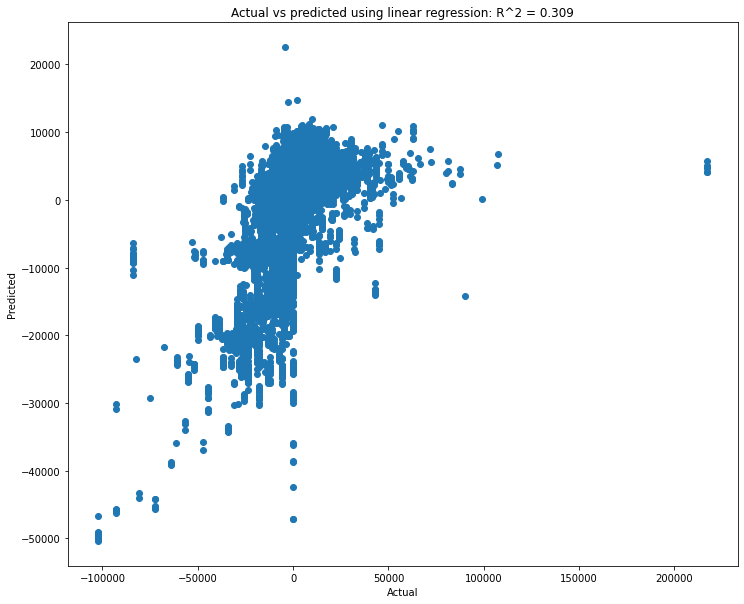

In [ ]:
fig = plt.figure(figsize=(12, 10))
# Note that we look at the predictions on the _test_ set
test_pred = lr.predict(X_test)
plt.scatter(y_test, test_pred)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs predicted using linear regression: R^2 = {np.corrcoef(y_test, test_pred)[0,1]**2:.3f}');

##Random Forest Regression for Ultra Slim Data

Ultra slim data is a small sample of our original data used to save time when analyzing.

###Training the data for random forest regression.

Creating a lst of columns we will not take into account. They make our model less accurate.

In [ ]:
bad_list = singleton_list + ['SK_ID_CURR','AMT_ANNUITY_x','AMT_APPLICATION','AMT_CREDIT','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE','RATE_DOWN_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT','AMT_ANNUITY_y']

In [ ]:
df_encoded2 = ultra_slim.drop(bad_list, axis=1)

Training our data with random forest regressor.

In [ ]:
rf_reg = RandomForestRegressor()

In [ ]:
train_df, test_df = train_test_split(df_encoded2, test_size=0.3)

feat_cols = df_encoded2.drop(columns = 'AMT_DIFF').columns.tolist()
target_col = 'AMT_DIFF'

X_train = train_df[feat_cols]
y_train = train_df[target_col]

X_test = test_df[feat_cols]
y_test = test_df[target_col]

rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (350000, 39)
Training Labels Shape: (350000,)
Testing Features Shape: (150000, 39)
Testing Labels Shape: (150000,)


In [ ]:
test_pred = rf_reg.predict(X_test)

for i in range(10):
    # We use [i] for test_pred because it's a list (actually a numpy array, basically the same thing)
    # We use .iloc[i] for y_test because it's a Pandas Series/DataFrame
    print(f'Predicted = {test_pred[i]}, Actual = {y_test.iloc[i]}')

Predicted = -25276.5, Actual = -25276.5
Predicted = -7362.0, Actual = -7362.0
Predicted = -32242.5, Actual = -32242.5
Predicted = 8608.5, Actual = 8608.5
Predicted = 0.0, Actual = 0.0
Predicted = 0.0, Actual = 0.0
Predicted = -18837.0, Actual = -18837.0
Predicted = 10125.0, Actual = 10125.0
Predicted = 1642.5, Actual = 1642.5
Predicted = 0.0, Actual = 0.0


Very good accuracy!!

In [ ]:
accuracy = rf_reg.score(X_test,y_test)
print(accuracy*100,'%')

99.78341000491972 %


Mean absolute error is only $47.75!

In [ ]:
# Evaluating the Algorithm
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, test_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_pred)))

Mean Absolute Error: 47.749455568156506
Mean Squared Error: 418575.520459993
Root Mean Squared Error: 646.9741265769389


Plotting actual vs fitted values for price difference.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


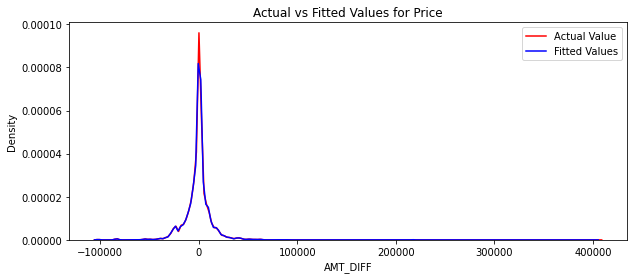

In [ ]:
plt.figure(figsize=(10, 4))
ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(test_pred, hist=False, color="b", label="Fitted Values" , 
             ax=ax)
ax.legend()
plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

###Finding feature importance.

In [ ]:
rf_reg.feature_importances_

array([1.83588514e-05, 5.15548314e-02, 9.24665716e-02, 6.80062995e-04,
       4.39537495e-02, 2.96732709e-02, 1.72250971e-02, 6.34942030e-02,
       4.08448498e-05, 2.46381387e-03, 2.13947602e-02, 1.21034990e-01,
       2.72189667e-01, 1.35329747e-01, 2.91982718e-02, 3.34235829e-02,
       1.64670798e-02, 9.36400549e-04, 8.54090712e-04, 4.36923483e-04,
       4.08899579e-04, 5.16700807e-03, 8.46961371e-03, 2.53742060e-03,
       9.89037948e-05, 4.45267434e-05, 2.37589973e-04, 1.46844812e-02,
       2.52099555e-06, 6.60742476e-03, 2.42381067e-03, 1.94645062e-03,
       1.12535667e-03, 8.82871122e-03, 3.28645953e-03, 2.36537173e-04,
       3.65031067e-06, 1.49229514e-03, 9.56202193e-03])

In [ ]:
feature_list = list(df_encoded2.columns)

In [ ]:
# Get numerical feature importances
importances = list(rf_reg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: NAME_SELLER_INDUSTRY Importance: 0.27
Variable: CNT_PAYMENT          Importance: 0.14
Variable: SELLERPLACE_AREA     Importance: 0.12
Variable: HOUR_APPR_PROCESS_START Importance: 0.09
Variable: NAME_GOODS_CATEGORY  Importance: 0.06
Variable: WEEKDAY_APPR_PROCESS_START Importance: 0.05
Variable: NAME_PAYMENT_TYPE    Importance: 0.04
Variable: NAME_TYPE_SUITE      Importance: 0.03
Variable: NAME_YIELD_GROUP     Importance: 0.03
Variable: PRODUCT_COMBINATION  Importance: 0.03
Variable: NAME_CLIENT_TYPE     Importance: 0.02
Variable: CHANNEL_TYPE         Importance: 0.02
Variable: NFLAG_INSURED_ON_APPROVAL Importance: 0.02
Variable: MONTHS_BALANCE       Importance: 0.01
Variable: CNT_INSTALMENT       Importance: 0.01
Variable: DAYS_CREDIT          Importance: 0.01
Variable: DAYS_CREDIT_ENDDATE  Importance: 0.01
Variable: AMT_CREDIT_SUM       Importance: 0.01
Variable: DAYS_CREDIT_UPDATE   Importance: 0.01
Variable: NAME_CONTRACT_TYPE   Importance: 0.0
Variable: NAME_CASH_LOAN_PU

In [ ]:
feature_importances

[('NAME_SELLER_INDUSTRY', 0.27),
 ('CNT_PAYMENT', 0.14),
 ('SELLERPLACE_AREA', 0.12),
 ('HOUR_APPR_PROCESS_START', 0.09),
 ('NAME_GOODS_CATEGORY', 0.06),
 ('WEEKDAY_APPR_PROCESS_START', 0.05),
 ('NAME_PAYMENT_TYPE', 0.04),
 ('NAME_TYPE_SUITE', 0.03),
 ('NAME_YIELD_GROUP', 0.03),
 ('PRODUCT_COMBINATION', 0.03),
 ('NAME_CLIENT_TYPE', 0.02),
 ('CHANNEL_TYPE', 0.02),
 ('NFLAG_INSURED_ON_APPROVAL', 0.02),
 ('MONTHS_BALANCE', 0.01),
 ('CNT_INSTALMENT', 0.01),
 ('DAYS_CREDIT', 0.01),
 ('DAYS_CREDIT_ENDDATE', 0.01),
 ('AMT_CREDIT_SUM', 0.01),
 ('DAYS_CREDIT_UPDATE', 0.01),
 ('NAME_CONTRACT_TYPE', 0.0),
 ('NAME_CASH_LOAN_PURPOSE', 0.0),
 ('NAME_PORTFOLIO', 0.0),
 ('NAME_PRODUCT_TYPE', 0.0),
 ('NUM_INSTALMENT_VERSION', 0.0),
 ('NUM_INSTALMENT_NUMBER', 0.0),
 ('DAYS_INSTALMENT', 0.0),
 ('DAYS_ENTRY_PAYMENT', 0.0),
 ('CNT_INSTALMENT_FUTURE', 0.0),
 ('SK_DPD', 0.0),
 ('SK_DPD_DEF', 0.0),
 ('CREDIT_ACTIVE', 0.0),
 ('CREDIT_DAY_OVERDUE', 0.0),
 ('DAYS_ENDDATE_FACT', 0.0),
 ('AMT_CREDIT_MAX_OVERDUE', 

In [ ]:
feature_importances1 = feature_importances.copy()

In [ ]:
feature_importances1_df = pd.DataFrame(feature_importances1, columns =['Feature', 'Importance'])

In [ ]:
feature_importances1_df = feature_importances1_df[(feature_importances1_df['Importance'] != 0)]

In [ ]:
feature_importances1_df

,Feature,Importance
0,NAME_SELLER_INDUSTRY,0.27
1,CNT_PAYMENT,0.14
2,SELLERPLACE_AREA,0.12
3,HOUR_APPR_PROCESS_START,0.09
4,NAME_GOODS_CATEGORY,0.06
5,WEEKDAY_APPR_PROCESS_START,0.05
6,NAME_PAYMENT_TYPE,0.04
7,NAME_TYPE_SUITE,0.03
8,NAME_YIELD_GROUP,0.03
9,PRODUCT_COMBINATION,0.03


In [ ]:
feature_importances1_df.shape

(19, 2)

Text(0.5, 1.0, 'Feature Importances')

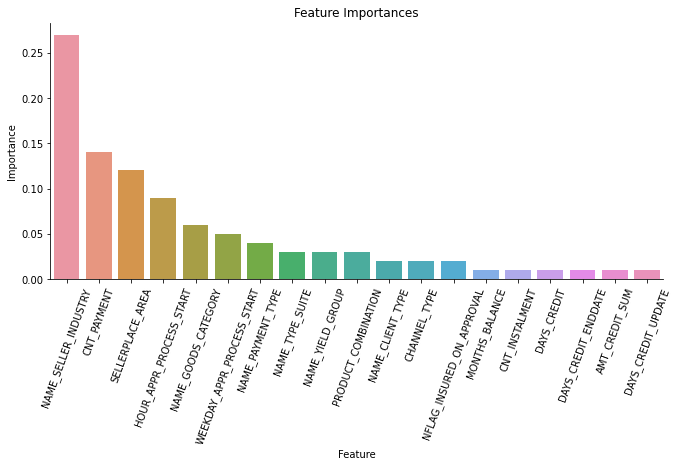

In [ ]:
g = sns.catplot(data = feature_importances1_df, x = feature_importances1_df['Feature'], y = feature_importances1_df['Importance'], 
                kind = 'bar')
g.set_xticklabels(rotation=70)
g.fig.set_size_inches(13, 4)
plt.title("Feature Importances")

##Random Forest Regression for Slim Data (TOO HEFTY)

Now that we have an efficient model for an slim, sampled dataset, we check its accuracy for a larger dataset

### Training the data for random forest regression.

In [ ]:
bad_list = singleton_list + ['SK_ID_CURR','AMT_ANNUITY_x','AMT_APPLICATION','AMT_CREDIT','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE','RATE_DOWN_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT','AMT_ANNUITY_y']

In [ ]:
bad_list

['FLAG_LAST_APPL_PER_CONTRACT',
 'NFLAG_LAST_APPL_IN_DAY',
 'NAME_CONTRACT_STATUS',
 'CODE_REJECT_REASON',
 'SK_ID_CURR',
 'AMT_ANNUITY_x',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'RATE_DOWN_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT',
 'AMT_ANNUITY_y']

In [ ]:
df_encoded3 = slim_sample_result3.drop(bad_list, axis=1)

Training random forest regressor.

In [ ]:
big_rf_reg = RandomForestRegressor()

In [ ]:
big_train_df, big_test_df = train_test_split(df_encoded3, test_size=0.3)

big_feat_cols = df_encoded3.drop(columns = 'AMT_DIFF').columns.tolist()
big_target_col = 'AMT_DIFF'

big_X_train = big_train_df[big_feat_cols]
big_y_train = big_train_df[big_target_col]

big_X_test = big_test_df[big_feat_cols]
big_y_test = big_test_df[big_target_col]

big_rf_reg.fit(big_X_train, big_y_train)

In [ ]:
print('Training Features Shape:', big_X_train.shape)
print('Training Labels Shape:', big_y_train.shape)
print('Testing Features Shape:', big_X_test.shape)
print('Testing Labels Shape:', big_y_test.shape)

Training Features Shape: (1969142, 39)
Training Labels Shape: (1969142,)
Testing Features Shape: (843918, 39)
Testing Labels Shape: (843918,)


In [ ]:
big_test_pred = big_rf_reg.predict(big_X_test)

for i in range(10):
    # We use [i] for test_pred because it's a list (actually a numpy array, basically the same thing)
    # We use .iloc[i] for y_test because it's a Pandas Series/DataFrame
    print(f'Predicted = {big_test_pred[i]}, Actual = {big_y_test.iloc[i]}')

In [ ]:
big_accuracy = big_rf_reg.score(big_X_test,big_y_test)
print(round(big_accuracy*100,8),'%')

In [ ]:
# Evaluating the Algorithm
print('Mean Absolute Error:', metrics.mean_absolute_error(big_y_test, big_test_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(big_y_test, big_test_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(big_y_test, big_test_pred)))

In [ ]:
plt.figure(figsize=(20, 7))
ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(test_pred, hist=False, color="b", label="Fitted Values" , 
             ax=ax)
ax.legend()
plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

### Finding feature importance

In [ ]:
big_rf_reg.feature_importances_

In [ ]:
big_feature_list = list(df_encoded3.columns)

In [ ]:
# Get numerical feature importances
big_importances = list(big_rf_reg.feature_importances_)
# List of tuples with variable and importance
big_feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(big_feature_list, big_importances)]
# Sort the feature importances by most important first
big_feature_importances = sorted(big_feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in big_feature_importances];

In [ ]:
big_feature_importances

In [ ]:
feature_importances2 = big_feature_importances.copy()

In [ ]:
feature_importances2_df = pd.DataFrame(feature_importances2, columns =['Feature', 'Importance'])

In [ ]:
feature_importances2_df = feature_importances2_df[(feature_importances2_df['Importance'] != 0)]

In [ ]:
feature_importances2_df

In [ ]:
feature_importances2_df.shape

In [ ]:
g = sns.catplot(data = feature_importances2_df, x = feature_importances2_df['Feature'], y = feature_importances2_df['Importance'], 
                kind = 'bar')
g.set_xticklabels(rotation=70)
g.fig.set_size_inches(20, 8)
plt.title("Feature Importances")

## Analyzing Feature Importance

`NAME_SELLER_INDUSTRY`: The industry of the seller

`CNT_PAYMENT`: Term of previous credit at application of the previous application

`SELLERPLACE_AREA`: Selling area of seller place of the previous application

`HOUR_APPR_PROCESS_START`: Approximately at what hour did the client apply for the loan

`NAME_GOODS_CATEGORY`: What kind of goods did the client apply for in the previous application

`WEEKDAY_APPR_PROCESS_START`: On which day of the week did the client apply for previous application

### NAME_SELLER_INDUSTRY

Analyzing the Name Seller Industry column.

Label encoding.

In [ ]:
industry_dict =  {0:'Consumer electronics', 1:'XNA', 2:'Connectivity', 3: 'Furniture', 4: 'Auto technology', 5: 'Clothing', 6: 'other', 7: 'Construction', 8: 'Jewlery', 9:'MLM partners', 10: 'Tourism'}

In [ ]:
ultra_slim['NAME_SELLER_INDUSTRY'] = ultra_slim['NAME_SELLER_INDUSTRY'].map(industry_dict)

In [ ]:
ultra_slim['NAME_SELLER_INDUSTRY'].nunique()

11

In [ ]:
ultra_slim['NAME_SELLER_INDUSTRY'].value_counts()

Auto technology         252089
Connectivity            106347
Tourism                  51868
Clothing                 32264
other                    19413
Furniture                19151
XNA                      17004
Consumer electronics       985
Construction               669
MLM partners               183
Jewlery                     27
Name: NAME_SELLER_INDUSTRY, dtype: int64

When applying for a loan, people who are going on vacation tend to be approved for more money. 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

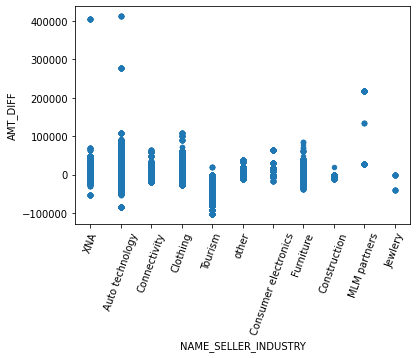

In [ ]:
nsi = ultra_slim.plot(kind='scatter', x= 'NAME_SELLER_INDUSTRY', y='AMT_DIFF')
plt.xticks(rotation=70)

In [ ]:
ultra_slim.groupby('NAME_SELLER_INDUSTRY')['AMT_DIFF'].median().sort_values(ascending=True)

NAME_SELLER_INDUSTRY
Tourism                 -14850.0
Auto technology              0.0
Construction                 0.0
Jewlery                      0.0
XNA                          0.0
other                        0.0
Furniture                  549.0
Clothing                   607.5
Connectivity               846.0
Consumer electronics     15911.1
MLM partners            217125.0
Name: AMT_DIFF, dtype: float64

### CNT_PAYMENT

If your remaining payments is at least 12 months on your previous credit, you tend to get approved for more money than what you applied for. 

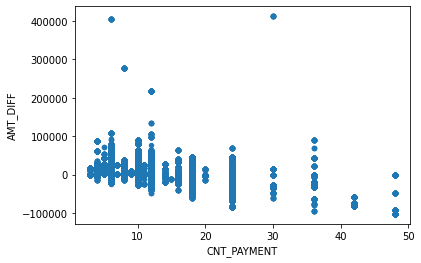

In [ ]:
ultra_slim.plot(kind='scatter', x= 'CNT_PAYMENT', y='AMT_DIFF')

In [ ]:
ultra_slim.groupby('CNT_PAYMENT')['AMT_DIFF'].median().sort_values(ascending=True)

CNT_PAYMENT
48   -102141.0
42    -56758.5
30    -34191.0
18    -15592.5
15    -12024.0
24     -4950.0
14       -81.0
36         0.0
20         0.0
16         0.0
12         0.0
11       891.0
6       1102.5
8       1233.0
10      1890.0
3       2502.0
5       3955.5
4       4500.0
9       5863.5
7      24907.5
Name: AMT_DIFF, dtype: float64

### SELLERPLACE_AREA

While the data is not arbitrary, the obscurity of the data renders it not currently viable for suggestions.

In [ ]:
slim_sample_result3['SELLERPLACE_AREA'].nunique()

In [ ]:
slim_sample_result3['SELLERPLACE_AREA'].value_counts()

In [ ]:
slim_sample_result3.plot(kind='scatter', x= 'SELLERPLACE_AREA', y='AMT_DIFF')

### HOUR_APPR_PROCESS_START

In [ ]:
ultra_slim['HOUR_APPR_PROCESS_START'].nunique()

23

In [ ]:
ultra_slim['HOUR_APPR_PROCESS_START'].max()

23

Apply at around 6am or 2pm (1-2pm in Central and Eastern Europe, CIS, China and South & South-East Asia) to get approved for more money. 

Avoid applying around 9pm or 10pm.

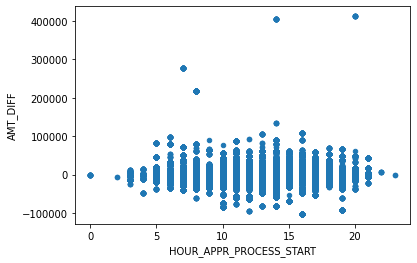

In [ ]:
ultra_slim.plot(kind='scatter', x= 'HOUR_APPR_PROCESS_START', y='AMT_DIFF')

In [ ]:
ultra_slim.groupby('HOUR_APPR_PROCESS_START')['AMT_DIFF'].median().sort_values(ascending=True)

HOUR_APPR_PROCESS_START
2    -6903.000
3    -3037.500
6    -2596.500
7    -1660.500
23   -1075.500
20       0.000
18       0.000
17       0.000
15       0.000
14       0.000
0        0.000
10       0.000
11       0.765
8      202.500
13     211.500
12     261.000
4      279.000
19     495.000
9      590.400
16     994.500
5     1827.000
21    3955.500
22    5818.500
Name: AMT_DIFF, dtype: float64

### NAME_GOODS_CATEGORY

Label encoding.

In [ ]:
nameGoods_Dict = {0:'Audio/Video', 1:'Consumer Electronics', 2:'Photo / Cinema Equipment', 3: 'XNA', 4: 'Mobile', 5: 'Computers', 6: 'Auto Accessories', 7: 'Furniture', 8: 'Clothing and Accessories', 9:  'Homewares', 10: 'Construction Materials', 11: 'Fitness', 12:  'Jewelry', 13: 'Gardening', 14: 'Vehicles', 15: 'Direct Sales', 16: 'Sport and Leisure', 17: 'Other', 18: 'Medical Supplies', 19: 'Tourism', 20: 'Medicine', 21: 'Office Appliances', 22: 'Insurance', 23: 'Additional Service', 24: 'Weapon', 25: 'Education', 26: 'House Construction'}

In [ ]:
ultra_slim['NAME_GOODS_CATEGORY'] = ultra_slim['NAME_GOODS_CATEGORY'].map(nameGoods_Dict)

In [ ]:
ultra_slim['NAME_GOODS_CATEGORY'].value_counts()

Other                       114995
Auto Accessories            102058
Consumer Electronics         69296
Education                    52175
Mobile                       47478
Construction Materials       36886
Computers                    20233
Medicine                     17402
XNA                          17043
Medical Supplies              4066
Photo / Cinema Equipment      3937
Office Appliances             3666
Tourism                       3034
Direct Sales                  2277
Vehicles                      2059
Additional Service            1491
Jewelry                       1134
Fitness                        528
Insurance                      183
Sport and Leisure               42
Furniture                        6
Gardening                        5
Homewares                        4
Audio/Video                      2
Name: NAME_GOODS_CATEGORY, dtype: int64

In [ ]:
ultra_slim['NAME_GOODS_CATEGORY'].nunique()

24

When applying for a loan, people spend on education tend to be approved for more money. 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 <a list of 24 Text major ticklabel objects>)

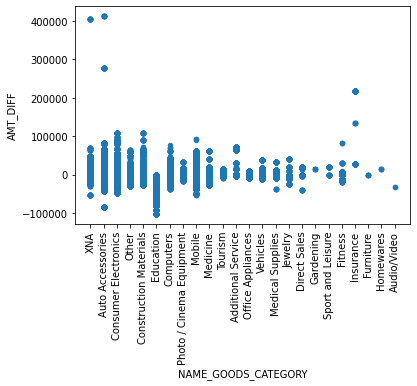

In [ ]:
ultra_slim.plot(kind='scatter', x= 'NAME_GOODS_CATEGORY', y='AMT_DIFF')
plt.xticks(rotation=90)

In [ ]:
ultra_slim.groupby('NAME_GOODS_CATEGORY')['AMT_DIFF'].median().sort_values(ascending=True)

NAME_GOODS_CATEGORY
Audio/Video                 -31482.0
Education                   -14850.0
Office Appliances            -1336.5
Medical Supplies             -1273.5
Additional Service               0.0
Tourism                          0.0
Mobile                           0.0
Jewelry                          0.0
Furniture                        0.0
XNA                              0.0
Consumer Electronics             0.0
Construction Materials           0.0
Auto Accessories               238.5
Photo / Cinema Equipment       306.0
Medicine                       391.5
Other                         1080.0
Computers                     1098.0
Vehicles                      1431.0
Fitness                       6984.0
Homewares                    13464.0
Gardening                    13495.5
Direct Sales                 19516.5
Sport and Leisure            20794.5
Insurance                   217125.0
Name: AMT_DIFF, dtype: float64

### WEEKDAY_APPR_PROCESS_START

In [ ]:
weekday_Dict = {0:'WEDNESDAY', 1:'MONDAY', 2:'THURSDAY', 3: 'SUNDAY', 4: 'FRIDAY', 5: 'TUESDAY', 6: 'SATURDAY'}

In [ ]:
ultra_slim['WEEKDAY_APPR_PROCESS_START'] = ultra_slim['WEEKDAY_APPR_PROCESS_START'].map(weekday_Dict)


In [ ]:
ultra_slim['WEEKDAY_APPR_PROCESS_START'].nunique()

7

In [ ]:
ultra_slim['WEEKDAY_APPR_PROCESS_START'].max()

'WEDNESDAY'

In [ ]:
day_order = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY', 'SUNDAY']

Best days for applying are Mondays with about $1,300 offered above the initial application amount.

Worst days for applying are Saturdays with about $575 offered below the initial application amount.


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

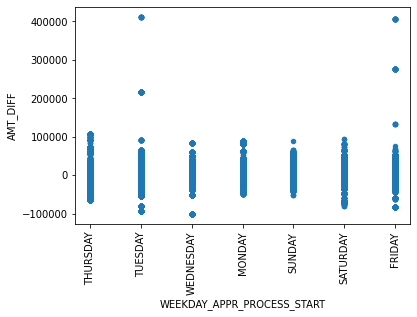

In [ ]:
waps = ultra_slim.plot(kind='scatter', x= 'WEEKDAY_APPR_PROCESS_START', y='AMT_DIFF')
plt.xticks(rotation=90)

In [ ]:
ultra_slim.groupby('WEEKDAY_APPR_PROCESS_START')['AMT_DIFF'].median().sort_values(ascending=True)

WEEKDAY_APPR_PROCESS_START
MONDAY      -1323.000
FRIDAY          0.000
SUNDAY          0.000
TUESDAY         0.000
THURSDAY        0.765
WEDNESDAY     351.000
SATURDAY      576.000
Name: AMT_DIFF, dtype: float64